## Packages

In [ ]:
# !pip install --upgrade tensorflow
# !pip install --upgrade tensorflow_privacy

In [ ]:
import os
import io
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')


## Data Cleaning

In [ ]:
v1 = pd.read_csv('/content/athletes.csv')
# Remove not relevant columns
v1['total_lift'] = v1[['deadlift','candj','snatch','backsq']].sum(axis=1)
v1 = v1.dropna(subset=['region','age','weight','height','howlong','gender','eat', \
                            'train','background','experience','schedule','howlong', \
                            'deadlift','candj','snatch','backsq','experience',\
                            'background','schedule','howlong'])
v1 = v1.drop(columns=['affiliate','team','name','athlete_id','fran','helen','grace',\
                          'filthy50','fgonebad','run400','run5k','pullups','train'])
v1 = v1[v1['gender'] != '--']

In [ ]:
def clean(data):
  # Remove Outliers
  data = data[data['weight'] < 1500]
  data = data[data['gender'] != '--']
  data = data[data['age'] >= 18]
  data = data[(data['height'] < 96) & (data['height'] > 48)]

  data = data[(data['deadlift'] > 0) & (data['deadlift'] <= 1105)|((data['gender'] == 'Female') \
                & (data['deadlift'] <= 636))]
  data = data[(data['candj'] > 0) & (data['candj'] <= 395)]
  data = data[(data['snatch'] > 0) & (data['snatch'] <= 496)]
  data = data[(data['backsq'] > 0) & (data['backsq'] <= 1069)]

  # Clean Survey Data

  decline_dict = {'Decline to answer|': np.nan}
  data = data.replace(decline_dict)
  data = data.dropna(subset=['background','experience','schedule','howlong','eat'])
  return data

In [ ]:
v2 = clean(v1)
v2.head()

,region,gender,age,height,weight,candj,snatch,deadlift,backsq,eat,background,experience,schedule,howlong,total_lift
21,Southern California,Male,30.0,71.0,200.0,235.0,175.0,385.0,315.0,I eat whatever is convenient|,I played youth or high school level sports|I p...,I began CrossFit by trying it alone (without a...,I do multiple workouts in a day 1x a week|I ty...,1-2 years|,1110.0
22,Africa,Male,28.0,70.0,176.0,187.0,134.0,335.0,254.0,I eat 1-3 full cheat meals per week|,I have no athletic background besides CrossFit|,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 1x a week|,2-4 years|,910.0
27,North East,Male,35.0,68.0,225.0,285.0,205.0,440.0,405.0,I eat quality foods but don't measure the amount|,I played youth or high school level sports|,I began CrossFit with a coach (e.g. at an affi...,I typically rest 4 or more days per month|,2-4 years|,1335.0
50,North Central,Male,36.0,71.0,199.0,267.0,212.0,485.0,390.0,I eat quality foods but don't measure the amount|,I played youth or high school level sports|I p...,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 3+ times a wee...,1-2 years|,1354.0
60,North East,Male,36.0,64.0,155.0,245.0,180.0,415.0,385.0,I eat strict Paleo|,I played youth or high school level sports|I p...,I began CrossFit by trying it alone (without a...,I do multiple workouts in a day 2x a week|I st...,4+ years|,1225.0


## EDA

In [ ]:
def EDA(df):
  cat_col = ['region', 'gender']
  for col in cat_col:
      counts = df[col].value_counts()
      fig, ax = plt.subplots(figsize=(6, 4))
      ax.pie(counts, labels=None, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel", len(counts)))
      ax.legend(title=col, labels=['%s: %d' % (label, value) for label, value in zip(counts.index, counts)], loc='center left', bbox_to_anchor=(1, 0.5))
      plt.title(f'Distribution of {col}')
      plt.show()
      plt.close()
  num_col = ['age', 'height', 'weight', 'candj', 'snatch', 'deadlift', 'backsq']
  if df is v2:
      summary = df[num_col].describe()
      print(summary)
      for col in num_col:
        plt.figure(figsize=(8, 5))
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()
  else:
    summary = df[num_col].describe()
    print(summary)


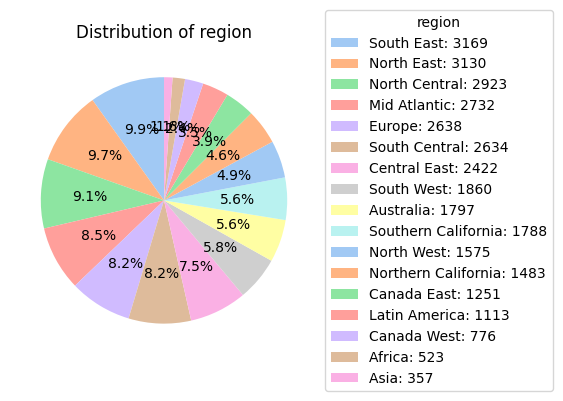

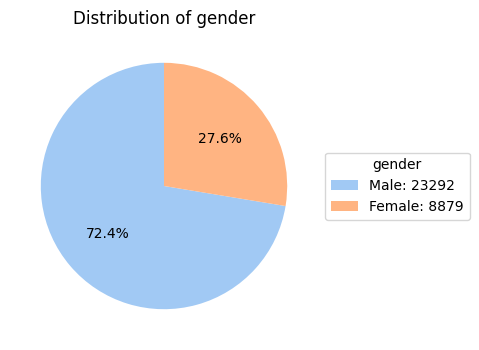

                age        height        weight         candj        snatch  \
count  32171.000000  3.217100e+04  32171.000000  32171.000000  32171.000000   
mean      32.039041  3.293817e+02    176.875540    200.768518    153.002704   
std        7.510302  4.676856e+04     33.551451     73.654959     73.819168   
min       14.000000  0.000000e+00      5.000000    -45.000000      0.000000   
25%       27.000000  6.600000e+01    155.000000    155.000000    115.000000   
50%       31.000000  6.900000e+01    178.000000    205.000000    155.000000   
75%       37.000000  7.200000e+01    196.000000    245.000000    190.000000   
max       56.000000  8.388607e+06   1750.000000   5000.000000   8095.000000   

           deadlift        backsq  
count  3.217100e+04  3.217100e+04  
mean   8.745018e+02  5.479982e+02  
std    6.613757e+04  4.676746e+04  
min   -5.000000e+02  0.000000e+00  
25%    2.800000e+02  2.250000e+02  
50%    3.650000e+02  2.950000e+02  
75%    4.300000e+02  3.550000e+02  


In [ ]:
EDA(v1)

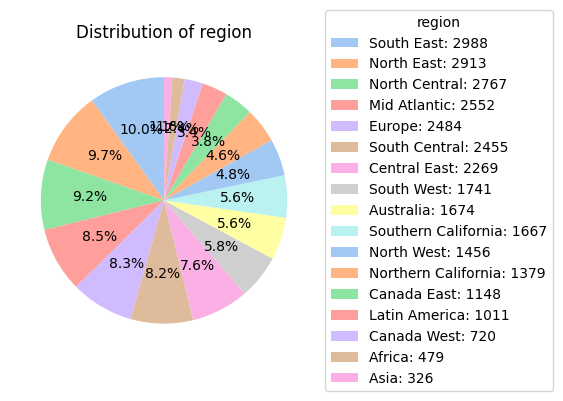

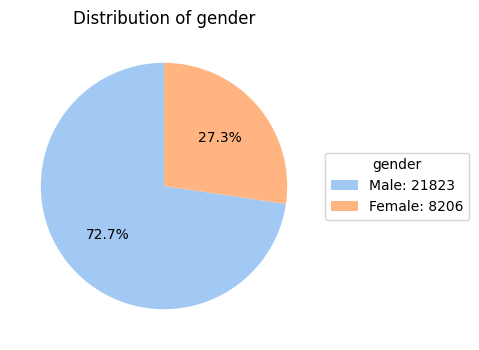

                age        height        weight         candj        snatch  \
count  30029.000000  30029.000000  30029.000000  30029.000000  30029.000000   
mean      32.123847     68.871924    177.130607    205.418396    156.174198   
std        7.435425      3.774937     32.399828     58.687508     48.833572   
min       18.000000     52.000000      5.000000      1.000000      1.000000   
25%       27.000000     66.000000    155.000000    160.000000    120.000000   
50%       31.000000     69.000000    178.000000    205.000000    155.000000   
75%       37.000000     72.000000    197.000000    245.000000    190.000000   
max       56.000000     83.000000    474.000000    390.000000    386.000000   

           deadlift        backsq  
count  30029.000000  30029.000000  
mean     361.933997    294.118818  
std       96.745441     85.081340  
min        0.000000      1.000000  
25%      287.000000    225.000000  
50%      375.000000    300.000000  
75%      434.000000    355.000000  


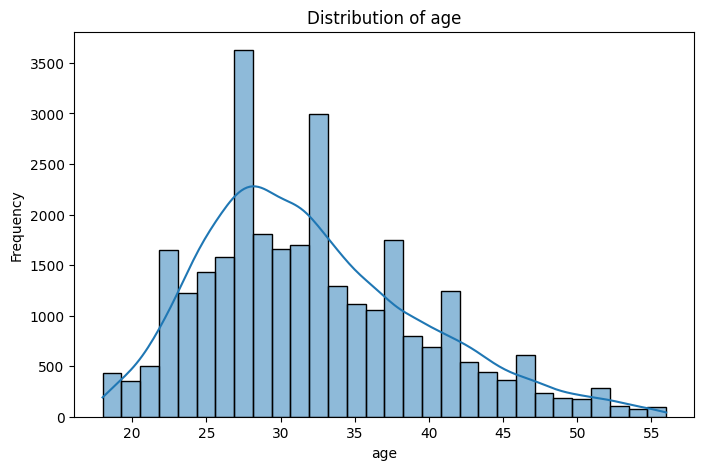

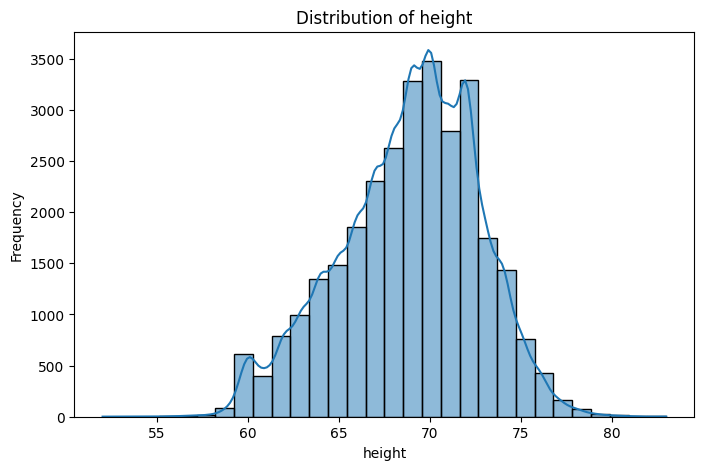

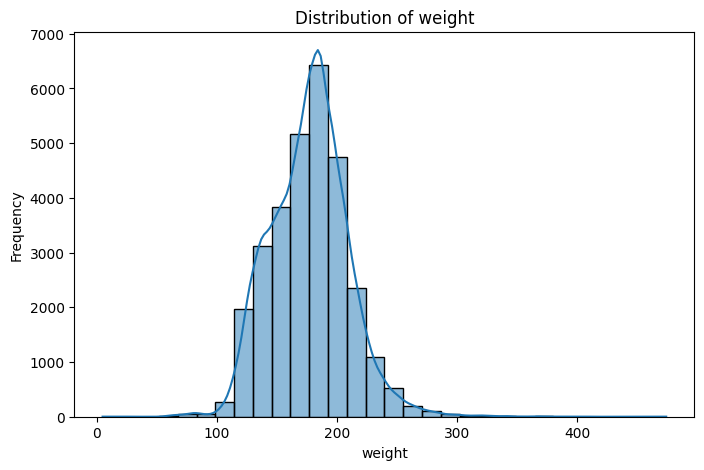

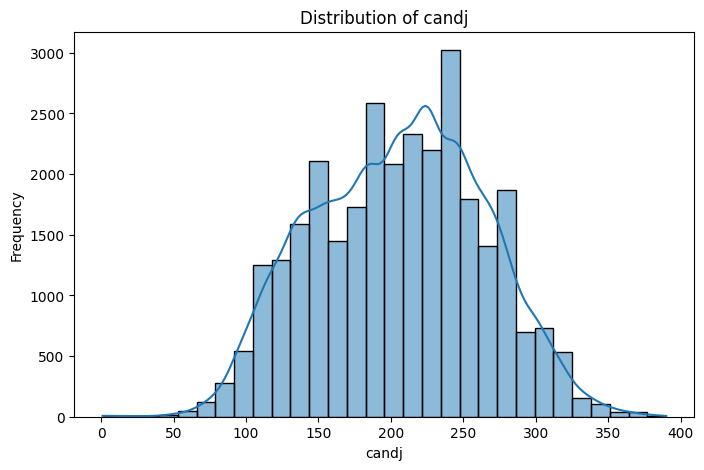

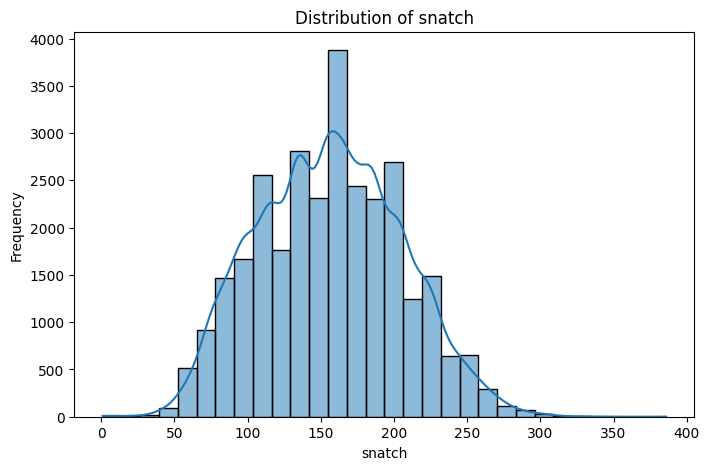

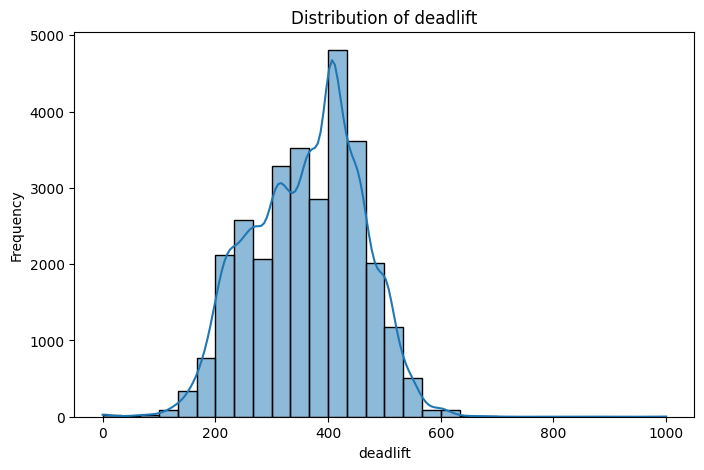

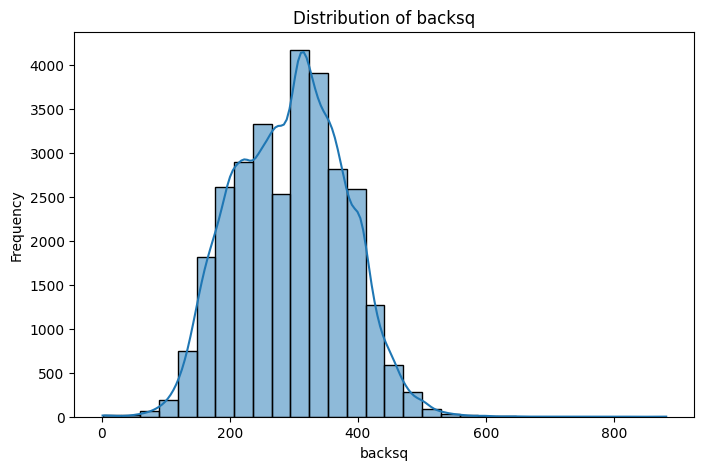

In [ ]:
EDA(v2)

## ML Model

In [ ]:
noise_multiplier = 1
num_microbatches = 1
l2_norm_clip = 0.5
learning_rate = 0.001
num_epochs = 10
def nonDP(df):
  X = df[['region', 'gender', 'age', 'height', 'weight']]
  y = df['total_lift']

  # One-hot encode categorical features and scale numeric features
  transformer = ColumnTransformer([
      ('cat', OneHotEncoder(), ['region', 'gender']),
      ('num', StandardScaler(), ['age', 'height', 'weight'])
  ])

  X = transformer.fit_transform(X)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(X_train.shape[1],)),
      tf.keras.layers.Dense(1)
  ])

  # Define the loss function and optimizer
  loss_function = tf.keras.losses.MeanSquaredError()
  non_dp_optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # Training loop for non-DP model
  non_dp_model = tf.keras.models.clone_model(model)
  non_dp_model.build(X_train.shape)
  non_dp_model.compile(optimizer=non_dp_optimizer, loss=loss_function)
  non_dp_model.fit(X_train.toarray(), y_train, epochs=num_epochs, verbose=0)

  # Calculate metrics for non-DP model
  non_dp_y_pred = non_dp_model.predict(X_test.toarray())
  non_dp_mse = mean_squared_error(y_test, non_dp_y_pred)
  non_dp_r_squared = r2_score(y_test, non_dp_y_pred)

  print("\nNon-Differentially Private Model:")
  print(f"MSE: {non_dp_mse}")
  print(f"R-squared: {non_dp_r_squared}")


## Delta Lake
#### Documentation: https://delta.io/blog/2022-10-15-version-pandas-dataset/

Write out the pandas DataFrame to a Delta table

In [ ]:
# !pip install deltalake
from deltalake import DeltaTable
from deltalake.writer import write_deltalake
os.makedirs("MLops/HW1", exist_ok=True)
write_deltalake("MLops/HW1", v1)
dt1 = DeltaTable("MLops/HW1")
dt1.to_pandas()

Overwrite the contents of the Delta table with a new DataFrame v2.

In [ ]:
write_deltalake("MLops/HW1", v2, mode="overwrite", overwrite_schema = True)

In [ ]:
DeltaTable("MLops/HW1").to_pandas().head()

In [ ]:
DeltaTable("MLops/HW1", version=0).to_pandas().head()

In [ ]:
nonDP(DeltaTable("MLops/HW1", version=0).to_pandas())

302/302 [==============================] - 1s 2ms/step

Non-Differentially Private Model:
MSE: 36468649263.64717
R-squared: -0.0001761089716387776


In [ ]:
nonDP(DeltaTable("MLops/HW1").to_pandas())

282/282 [==============================] - 0s 1ms/step

Non-Differentially Private Model:
MSE: 30383.447177608185
R-squared: 0.6029031434125579


## DP Model

In [ ]:
tf.compat.v1.disable_v2_behavior()
from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPGradientDescentGaussianOptimizer
from tensorflow_privacy.privacy.analysis.compute_dp_sgd_privacy_lib import compute_dp_sgd_privacy_statement

def DP(df):
  X = df[['region', 'gender', 'age', 'height', 'weight']]
  y = df['total_lift']

  # One-hot encode categorical features and scale numeric features
  transformer = ColumnTransformer([
      ('cat', OneHotEncoder(), ['region', 'gender']),
      ('num', StandardScaler(), ['age', 'height', 'weight'])
  ])

  X = transformer.fit_transform(X)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(X_train.shape[1],)),
      tf.keras.layers.Dense(1)
  ])

  # Define the loss function and optimizer
  loss_function = tf.keras.losses.MeanSquaredError()
  dp_optimizer = DPGradientDescentGaussianOptimizer(
      l2_norm_clip=l2_norm_clip,
      noise_multiplier=noise_multiplier,
      num_microbatches=num_microbatches,
      learning_rate=learning_rate)

  # Training loop for DP model
  dp_model = tf.keras.models.clone_model(model)
  dp_model.build(X_train.shape)
  dp_model.compile(optimizer=dp_optimizer, loss=loss_function)
  dp_model.fit(X_train.toarray(), y_train, epochs=num_epochs, verbose=0)

  # Calculate metrics for DP model
  dp_y_pred = dp_model.predict(X_test.toarray())
  dp_mse = mean_squared_error(y_test, dp_y_pred)
  dp_r_squared = r2_score(y_test, dp_y_pred)

  print("\nDifferentially Private Model:")
  print(f"MSE: {dp_mse}")
  print(f"R-squared: {dp_r_squared}")

  # Calculate the epsilon
  epsilon = compute_dp_sgd_privacy_statement(
      number_of_examples=len(X_train.toarray()),
      batch_size=len(X_train.toarray()) // num_microbatches,
      noise_multiplier=noise_multiplier,
      num_epochs=num_epochs,
      delta=1e-5
  )
  print(f"Epsilon: {epsilon}")


Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
DP(DeltaTable("MLops/HW1").to_pandas())


Differentially Private Model:
MSE: 1103577.8894733265
R-squared: -13.423225526306432
Epsilon: DP-SGD performed over 21020 examples with 21020 examples per iteration, noise
multiplier 1 for 10 epochs with microbatching, and no bound on number of
examples per user.

This privacy guarantee protects the release of all model checkpoints in addition
to the final model.

Example-level DP with add-or-remove-one adjacency at delta = 1e-05 computed with
RDP accounting:
    Epsilon with each example occurring once per epoch:        48.802
    Epsilon assuming Poisson sampling (*):                     48.802

No user-level privacy guarantee is possible without a bound on the number of
examples per user.

(*) Poisson sampling is not usually done in training pipelines, but assuming
that the data was randomly shuffled, it is believed the actual epsilon should be
closer to this value than the conservative assumption of an arbitrary data
order.

